# Imports and Function Definitions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astroquery.sdss import SDSS
from scipy.stats import norm
from KDEpy import NaiveKDE, FFTKDE, TreeKDE
from scipy import stats
from matplotlib.colors import LogNorm
plt.rcParams["figure.figsize"] = (8,8)


In [3]:
N = 50_000

pos_query = f"""
SELECT TOP {N}
    z, ra, dec
FROM
    specObj
WHERE
    class = 'galaxy'  
    and zWarning = 0
    and z > 0
    and ra > 110
    and ra < 265"""

color_query = f"""
SELECT TOP {N}
    size, psfMag_u, psfMag_r
FROM
    PhotoObjDR7
WHERE
    type = 3 
""" # type 3 == galaxy


pos_data = np.array(SDSS.query_sql(pos_query))
redshifts = [x[0] for x in pos_data]
ras = [x[1] for x in pos_data]
decs = [x[2] for x in pos_data]


color_data = np.array(SDSS.query_sql(color_query))
size = np.array([x[0] for x in color_data])
colors = np.array([x[1] - x[2] for x in color_data])

idxs = np.where((size < 6)&(size > 0)&(colors > -5))
size = size[idxs]
colors = colors[idxs]


# 2D plot of z and ra

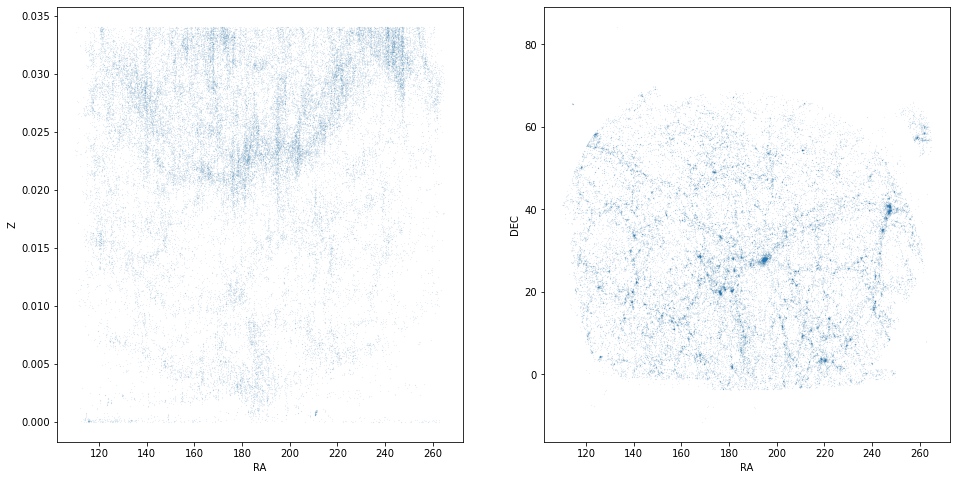

In [4]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

POINT_SIZE = 0.001

axs[0].scatter(ras, redshifts, s=POINT_SIZE)
axs[0].set_xlabel("RA")
axs[0].set_ylabel("Z")

axs[1].scatter(ras, decs, s=POINT_SIZE)
axs[1].set_xlabel("RA")
axs[1].set_ylabel("DEC")

plt.show()

In [5]:
H = 0.04

zmin, zmax = min(redshifts), max(redshifts)
rmin, rmax = min(ras), max(ras)
dmin, dmax = min(decs), max(decs)

z_ra_X, z_ra_Y = np.mgrid[rmin:rmax:500j, zmin:zmax:500j]
positions = np.vstack([z_ra_X.ravel(), z_ra_Y.ravel()])
values = np.vstack([ras, redshifts])
kernel = stats.gaussian_kde(values, bw_method=H)
z_ra = np.reshape(kernel(positions).T, z_ra_X.shape)

ra_dec_X, ra_dec_Y = np.mgrid[rmin:rmax:500j, dmin:dmax:500j]
positions = np.vstack([ra_dec_X.ravel(), ra_dec_Y.ravel()])
values = np.vstack([ras, decs])
kernel = stats.gaussian_kde(values, bw_method=H)
ra_dec = np.reshape(kernel(positions).T, ra_dec_X.shape)


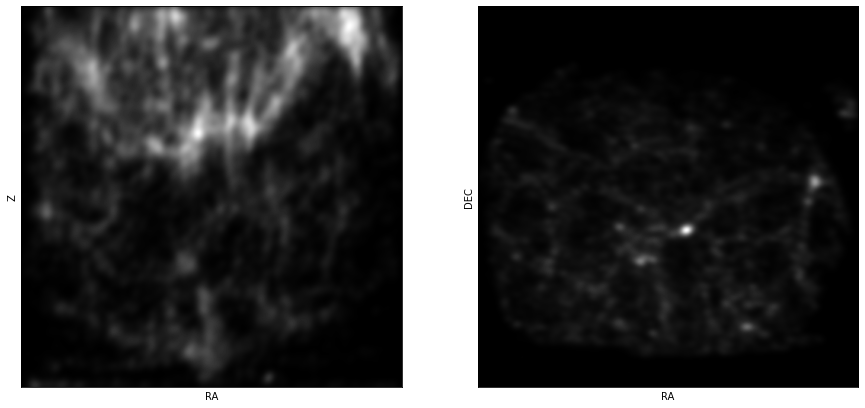

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15,10), sharex=True)

# axs[1].contour(z_ra, norm=LogNorm())
axs[0].imshow(np.rot90(z_ra), cmap="gray")
# axs[0].contour(np.rot90(z_ra), norm=LogNorm())
axs[0].set_xlabel("RA")
axs[0].set_ylabel("Z")
axs[0].set_yticks([])
axs[0].set_xticks([])

# axs[0].contour(ra_dec, norm=LogNorm())
axs[1].imshow(np.rot90(ra_dec), cmap="gray")
# axs[1].contour(np.rot90(ra_dec), norm=LogNorm())
axs[1].set_xlabel("RA")
axs[1].set_ylabel("DEC")
axs[1].set_yticks([])
axs[1].set_xticks([])

plt.show()

In [7]:
cmin, cmax = min(colors), max(colors)
smin, smax = min(size), max(size)


X, Y = np.mgrid[smin:smax:500j, cmin:cmax:500j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([size, colors])
kernel = stats.gaussian_kde(values, bw_method=H)
s_c = np.reshape(kernel(positions).T, X.shape)

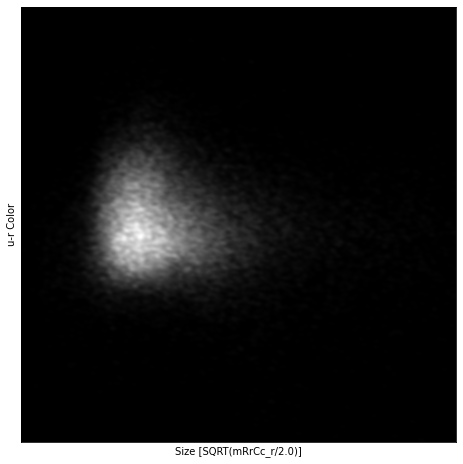

In [8]:
plt.imshow(np.rot90(s_c), cmap="gray")
# plt.contour(np.rot90(s_c), levels=10)
plt.xlabel("Size [SQRT(mRrCc_r/2.0)]")
plt.ylabel("u-r Color")
plt.yticks([])
plt.xticks([])
plt.show()